In [1]:
import yasa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import decimate
import mne
import os
import glob

In [2]:
from initial_processes import *

In [32]:
def load_32_EEG_by_state(foldername, montage_name, source_number, brain_states, brain_state, downsampling):

    'Below are 2 functions from OpenEphys to load data channels and auxilary (accelerometer) channels'
    data=loadFolderToArray(foldername, channels = 'all', chprefix = 'CH', dtype = float, session = '0', source = source_number)
    data_aux=loadFolderToArray(foldername, channels = 'all', chprefix = 'AUX', dtype = float, session = '0', source = source_number)

    #data=loadFolderToArray(prm.get_filepath(), channels = 'all', chprefix = 'CH', dtype = float, session = '0', source = '101')
    #data_aux=loadFolderToArray(prm.get_filepath(), channels = 'all', chprefix = 'AUX', dtype = float, session = '0', source = '101')

    'Below we append a line to the data array and add the accelrometer data. We transpose to fit the MNE data format.'
    data = np.append(data, (np.zeros((data.shape[0],1), dtype=int64)), axis=1)
    #data[:,32]=data_aux[:,0]*800 # zeros

    # As the bins are for every 5 seconds, we need to create an array repeating those states per each ms*downsampling
    brain_states_ms = np.repeat(brain_states, 5000/downsampling)
    
    # Downsampling
    raw_data_downsampled = []
    for i in np.arange(33):
        raw_data_downsampled.append(decimate(data[:,i], downsampling))    
    
    # 34d array. First for states, then for the electrodes
    state_voltage_list = [brain_states_ms]
    size_brain_states = np.size(brain_states_ms)
    for i in np.arange(33):
        state_voltage_list.append(raw_data_downsampled[i][0:size_brain_states])   
    
    state_voltage_array = np.stack(state_voltage_list)
    
    # Amplitude filter
    amp_filter = 750
    state_voltage_array = state_voltage_array[:, abs(state_voltage_array[2,:]) < amp_filter]
    
    # Only takes the voltages with a certain brain state
    volt_by_state = state_voltage_array[1:, state_voltage_array[0,:] == brain_state]
    
    #yasa expect volts, but we are recording in uV
    datatp=volt_by_state #Array from openephys has to be transposed to match RawArray MNE function to create.
    
    del data
    
    
    if isinstance('montage_name', str):
        montage = mne.channels.read_custom_montage(montage_name)
    else:
        print("The montage name is not valid")

    channel_types=['eeg','eeg','eeg','eeg','eeg','eeg', 'eeg', 'eeg',
                   'eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg'
                   ,'eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg'
                   ,'eeg','eeg','eeg','eeg','eeg','eeg','eeg','eeg', 'emg'] # not necessario in new version, 'emg', 'emg', 'emg']

    info = mne.create_info(montage.ch_names[0:33], prm.get_sampling_rate(), ch_types=channel_types)

    'This makes the object that contains all the data and info about the channels.'
    'Computations like plotting, averaging, power spectrums can be performed on this object'

    custom_raw = mne.io.RawArray( datatp, info)
    del datatp
    return custom_raw

In [33]:
def electrode_combinations(montage_name, neighbors_dist, long_distance, n_elect = 32):
  montage = mne.channels.read_custom_montage(montage_name)
  electrode_names = montage.ch_names[0:n_elect]
  electrode_pos = np.zeros((32,2))
  for i in np.arange(32):
    electrode_pos[i] = montage.dig[i+3].get('r')[0:2].round(3)*50 # in mm

  distances_btw_electrodes = spatial.distance.pdist(electrode_pos, 'euclidean')

  nums = np.linspace(0, n_elect-1, n_elect, dtype = int)

  comb = combinations(nums, 2)
  # working with the combination element is difficult and it can only be assigned once -> it is transformed into a list
  comb_long_distance = list(comb)

  comb = combinations(nums, 2)
  comb_short_distance = list(comb)

  # indexes for the elements to delete
  indexes_to_delete_in_short_distance = []
  indexes_to_delete_in_long_distance = []

  nei = 0
  s_d = 0
  l_d = 0

  for i in range(len(distances_btw_electrodes)):
      if distances_btw_electrodes[i] <= neighbors_dist:
          indexes_to_delete_in_long_distance.append(i)
          indexes_to_delete_in_short_distance.append(i)
          nei += 1
      elif distances_btw_electrodes[i] <long_distance:
          indexes_to_delete_in_long_distance.append(i)
          s_d += 1
      else:
          indexes_to_delete_in_short_distance.append(i)
          l_d += 1

  long_dist_electrodes = np.delete(distances_btw_electrodes, indexes_to_delete_in_long_distance)
  short_dist_electrodes = np.delete(distances_btw_electrodes, indexes_to_delete_in_short_distance)

  # when it deletes an element, it is necessary to update the indexes substracting one to the total of them the list has.
  indexes_already_del = 0
  for i in range(len(indexes_to_delete_in_long_distance)):
      del comb_long_distance[indexes_to_delete_in_long_distance[i] - indexes_already_del]
      indexes_already_del += 1

  indexes_already_del = 0
  for i in range(len(indexes_to_delete_in_short_distance)):
      del comb_short_distance[indexes_to_delete_in_short_distance[i] - indexes_already_del]
      indexes_already_del += 1

  return comb_short_distance, comb_long_distance

In [34]:
ko_folder = '/media/jorge/DATADRIVE0/Data/Alfredo/Syngap/KO/'
wt_folder = '/media/jorge/DATADRIVE0/Data/Alfredo/Syngap/WT/'

In [35]:
montage_name = '/media/jorge/DATADRIVE0/Code/MNE_Alfredo/standard_32grid_Alfredo.elc'
n_electrodes = 32
neighbors_dist = 0.5
long_distance = 2

prm.set_sampling_rate(1000)
sr=prm.get_sampling_rate()
downsampling = 8
brain_state = 1 # NonREM

### Get the files and folders to analyse

In [36]:
l_folders_KO = []
l_xls_files_KO = []
l_folders_WT = []
l_xls_files_WT = []

# dividing files by animal (KO)
os.chdir(ko_folder)
d = os.getcwd() + '/'
matching_files = glob.glob(r'*xls')
for matching_file in matching_files:
    l_xls_files_KO.append(d+matching_file)
    l_folders_KO.append(d+ matching_file.replace('_States.xls', '') + '/')    

# dividing files by animal (WT)
os.chdir(wt_folder)
d = os.getcwd() + '/'
matching_files = glob.glob(r'*xls')
for matching_file in matching_files:
    l_xls_files_WT.append(d+matching_file)
    l_folders_WT.append(d+matching_file.replace('_States.xls', '') + '/')

### Calculating the combinations for short and long distance

In [37]:
short_d_comb, long_d_comb = electrode_combinations(montage_name, neighbors_dist, long_distance, n_electrodes)

In [38]:
len(short_d_comb)

112

In [39]:
len(long_d_comb)

384

### Calculate the spindles happening together when comparing combinations of electrodes at a short or long distance. Changes from the default. We are looking for coincidences of spindles with frequencies from 13-17 Hz with a center in 15 Hz.

In [40]:
list_sp_multi_WT = []
list_sp_WT = []
total_samples_WT = []
total_seconds_WT = []
sp_per_recording_WT = []
for i, xls_file in enumerate(l_xls_files_WT):
    # First extract data for the whole recording but just for the NonREM state
    brain_states = import_brain_states(xls_file)
    raw_data = load_32_EEG_by_state(l_folders_WT[i], montage_name, '100', brain_states, brain_state, downsampling)
    total_samples_WT.append(raw_data.n_times)
    total_seconds_WT.append(raw_data.n_times/(sr/downsampling))
    # Go through all the combinations on that recording
    # Short distances
    sp_short_WT = []
    for i in list(short_d_comb): 
        data = np.vstack((raw_data._data[i[0]], raw_data._data[i[1]]))
        names = [raw_data.ch_names[i[0]],raw_data.ch_names[i[1]]]
        sp = yasa.spindles_detect(data, sf = sr/downsampling, ch_names = names, freq_sp=(13,17), multi_only=True, remove_outliers=True)
        sp_short_WT.append(sp)
        
    sp_per_recording_WT.append(list(filter(None, sp_short_WT))) # there are some sp that are empty
    # Long distance
    print('recording done:')
    print(xls_file)

 Openning Excelfile /media/jorge/DATADRIVE0/Data/Alfredo/Syngap/WT/S7018_D5_States.xls
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Avg. Load Time: 2.946582242846489 sec
Total Load 

06-Apr-21 20:12:23 | WARNING | No spindle were found in channel V2L_V1B_LEFT.
06-Apr-21 20:12:53 | WARNING | No spindle were found in channel V2L_V1B_LEFT.
06-Apr-21 20:13:02 | WARNING | No spindle were found in channel V2L_V1B_LEFT.
06-Apr-21 20:13:06 | WARNING | No spindle were found in channel V2L_V1B_LEFT.
06-Apr-21 20:13:13 | WARNING | No spindle were found in channel V2L_V1B_LEFT.


recording done:
/media/jorge/DATADRIVE0/Data/Alfredo/Syngap/WT/S7018_D5_States.xls
 Openning Excelfile /media/jorge/DATADRIVE0/Data/Alfredo/Syngap/WT/S7018_D6_States.xls
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous d

06-Apr-21 20:23:19 | WARNING | No spindle were found in channel V1M_LEFT.
06-Apr-21 20:23:30 | WARNING | No spindle were found in channel V2MM_LEFT.
06-Apr-21 20:23:31 | WARNING | No spindle were found in channel V1M_LEFT.
06-Apr-21 20:23:35 | WARNING | No spindle were found in channel V2MM_LEFT.
06-Apr-21 20:23:36 | WARNING | No spindle were found in channel V1M_LEFT.
06-Apr-21 20:23:40 | WARNING | No spindle were found in channel V1M_LEFT.
06-Apr-21 20:23:41 | WARNING | No spindle were found in channel V2MM_LEFT.
06-Apr-21 20:23:42 | WARNING | No spindle were found in channel V1M_LEFT.
06-Apr-21 20:23:42 | WARNING | No spindles were found in data. Returning None.
06-Apr-21 20:23:42 | WARNING | No spindle were found in channel V2MM_LEFT.
06-Apr-21 20:23:43 | WARNING | No spindle were found in channel V2MM_LEFT.
06-Apr-21 20:23:44 | WARNING | No spindle were found in channel V2MM_LEFT.
06-Apr-21 20:23:45 | WARNING | No spindle were found in channel V1M_LEFT.


recording done:
/media/jorge/DATADRIVE0/Data/Alfredo/Syngap/WT/S7031_D2-B_States.xls
 Openning Excelfile /media/jorge/DATADRIVE0/Data/Alfredo/Syngap/WT/S7032_D2-A_States.xls
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuo

06-Apr-21 20:36:13 | WARNING | No spindle were found in channel S1Tr_LEFT.
06-Apr-21 20:36:13 | WARNING | No spindle were found in channel S1Tr_LEFT.
06-Apr-21 20:36:13 | WARNING | No spindle were found in channel S1Tr_LEFT.
06-Apr-21 20:36:14 | WARNING | No spindle were found in channel V2ML_LEFT.
06-Apr-21 20:36:14 | WARNING | No spindles were found in data. Returning None.
06-Apr-21 20:36:14 | WARNING | No spindle were found in channel S1Tr_LEFT.
06-Apr-21 20:36:14 | WARNING | No spindle were found in channel V2L_LEFT.
06-Apr-21 20:36:14 | WARNING | No spindles were found in data. Returning None.
06-Apr-21 20:36:14 | WARNING | No spindle were found in channel S1Tr_LEFT.
06-Apr-21 20:36:14 | WARNING | No spindle were found in channel V1M_LEFT.
06-Apr-21 20:36:14 | WARNING | No spindles were found in data. Returning None.
06-Apr-21 20:36:14 | WARNING | No spindle were found in channel S1Tr_LEFT.
06-Apr-21 20:36:15 | WARNING | No spindle were found in channel M2_post_LEFT.
06-Apr-21 20

06-Apr-21 20:36:39 | WARNING | No spindle were found in channel S1DZ_S1Bf_RIGHT.
06-Apr-21 20:36:39 | WARNING | No spindles were found in data. Returning None.
06-Apr-21 20:36:39 | WARNING | No spindle were found in channel M2_post_RIGHT.
06-Apr-21 20:36:39 | WARNING | No spindle were found in channel S1Tr_RIGHT.
06-Apr-21 20:36:39 | WARNING | No spindles were found in data. Returning None.
06-Apr-21 20:36:40 | WARNING | No spindle were found in channel V2L_V1B_RIGHT.
06-Apr-21 20:36:40 | WARNING | No spindle were found in channel V1M_RIGHT.
06-Apr-21 20:36:40 | WARNING | No spindles were found in data. Returning None.
06-Apr-21 20:36:40 | WARNING | No spindle were found in channel V2L_V1B_RIGHT.
06-Apr-21 20:36:40 | WARNING | No spindle were found in channel V2L_V1B_RIGHT.
06-Apr-21 20:36:40 | WARNING | No spindle were found in channel V2L_RIGHT.
06-Apr-21 20:36:40 | WARNING | No spindles were found in data. Returning None.
06-Apr-21 20:36:40 | WARNING | No spindle were found in chann

recording done:
/media/jorge/DATADRIVE0/Data/Alfredo/Syngap/WT/S7026_D2-A_States.xls
 Openning Excelfile /media/jorge/DATADRIVE0/Data/Alfredo/Syngap/WT/S7026_D3_States.xls
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous

06-Apr-21 20:42:16 | WARNING | No spindle were found in channel V2L_V1B_RIGHT.
06-Apr-21 20:42:18 | WARNING | No spindle were found in channel V2L_V1B_RIGHT.
06-Apr-21 20:42:20 | WARNING | No spindle were found in channel V2L_V1B_RIGHT.
06-Apr-21 20:42:21 | WARNING | No spindle were found in channel V2L_V1B_RIGHT.
06-Apr-21 20:42:23 | WARNING | No spindle were found in channel V2L_V1B_RIGHT.


recording done:
/media/jorge/DATADRIVE0/Data/Alfredo/Syngap/WT/S7026_D3_States.xls
 Openning Excelfile /media/jorge/DATADRIVE0/Data/Alfredo/Syngap/WT/S7030_D2_States.xls
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous d

06-Apr-21 21:00:40 | WARNING | No spindle were found in channel V2L_V1B_RIGHT.
06-Apr-21 21:00:42 | WARNING | No spindle were found in channel V2L_V1B_RIGHT.
06-Apr-21 21:00:44 | WARNING | No spindle were found in channel V2L_V1B_RIGHT.
06-Apr-21 21:00:45 | WARNING | No spindle were found in channel V2L_V1B_RIGHT.
06-Apr-21 21:00:47 | WARNING | No spindle were found in channel V2L_V1B_RIGHT.


recording done:
/media/jorge/DATADRIVE0/Data/Alfredo/Syngap/WT/S7026_D2-B_States.xls
 Openning Excelfile /media/jorge/DATADRIVE0/Data/Alfredo/Syngap/WT/S7031_D2-A_States.xls
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuo

06-Apr-21 21:02:38 | WARNING | No spindle were found in channel V1M_LEFT.
06-Apr-21 21:02:46 | WARNING | No spindle were found in channel V2L_V1B_LEFT.
06-Apr-21 21:02:54 | WARNING | No spindle were found in channel V1M_LEFT.
06-Apr-21 21:03:00 | WARNING | No spindle were found in channel V1M_LEFT.
06-Apr-21 21:03:01 | WARNING | No spindle were found in channel V2L_V1B_LEFT.
06-Apr-21 21:03:04 | WARNING | No spindle were found in channel V1M_LEFT.
06-Apr-21 21:03:05 | WARNING | No spindle were found in channel V2L_V1B_LEFT.
06-Apr-21 21:03:07 | WARNING | No spindle were found in channel V1M_LEFT.
06-Apr-21 21:03:08 | WARNING | No spindle were found in channel V2L_V1B_LEFT.
06-Apr-21 21:03:10 | WARNING | No spindle were found in channel V2MM_RIGHT.
06-Apr-21 21:03:11 | WARNING | No spindle were found in channel V1M_LEFT.
06-Apr-21 21:03:11 | WARNING | No spindle were found in channel V2L_V1B_LEFT.
06-Apr-21 21:03:11 | WARNING | No spindles were found in data. Returning None.
06-Apr-21 2

recording done:
/media/jorge/DATADRIVE0/Data/Alfredo/Syngap/WT/S7031_D2-A_States.xls
 Openning Excelfile /media/jorge/DATADRIVE0/Data/Alfredo/Syngap/WT/S7032_D2-B_States.xls
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuo

06-Apr-21 21:08:06 | WARNING | No spindle were found in channel V1M_LEFT.
06-Apr-21 21:08:08 | WARNING | No spindle were found in channel V2L_V1B_LEFT.
06-Apr-21 21:08:10 | WARNING | No spindle were found in channel V1M_LEFT.
06-Apr-21 21:08:11 | WARNING | No spindle were found in channel V2MM_RSA_RIGHT.
06-Apr-21 21:08:12 | WARNING | No spindle were found in channel V1M_LEFT.
06-Apr-21 21:08:12 | WARNING | No spindle were found in channel V2L_V1B_LEFT.
06-Apr-21 21:08:13 | WARNING | No spindle were found in channel V1M_LEFT.
06-Apr-21 21:08:13 | WARNING | No spindle were found in channel V2L_V1B_LEFT.
06-Apr-21 21:08:14 | WARNING | No spindle were found in channel V1M_LEFT.
06-Apr-21 21:08:14 | WARNING | No spindle were found in channel V2L_V1B_LEFT.
06-Apr-21 21:08:15 | WARNING | No spindle were found in channel V1M_LEFT.
06-Apr-21 21:08:15 | WARNING | No spindle were found in channel V2L_V1B_LEFT.
06-Apr-21 21:08:15 | WARNING | No spindles were found in data. Returning None.
06-Apr-

recording done:
/media/jorge/DATADRIVE0/Data/Alfredo/Syngap/WT/S7034_D3-A_States.xls
 Openning Excelfile /media/jorge/DATADRIVE0/Data/Alfredo/Syngap/WT/S7036_D3-A_States.xls
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuo

06-Apr-21 21:09:46 | WARNING | No spindle were found in channel S1HL_S1FL_LEFT.
06-Apr-21 21:09:52 | WARNING | No spindle were found in channel S1HL_S1FL_LEFT.
06-Apr-21 21:10:04 | WARNING | No spindle were found in channel S1HL_S1FL_LEFT.
06-Apr-21 21:10:11 | WARNING | No spindle were found in channel S1HL_S1FL_LEFT.
06-Apr-21 21:10:14 | WARNING | No spindle were found in channel S1HL_S1FL_LEFT.
06-Apr-21 21:10:15 | WARNING | No spindle were found in channel S1HL_S1FL_LEFT.
06-Apr-21 21:10:16 | WARNING | No spindle were found in channel S1HL_S1FL_LEFT.
06-Apr-21 21:10:17 | WARNING | No spindle were found in channel S1HL_S1FL_LEFT.
06-Apr-21 21:10:18 | WARNING | No spindle were found in channel S1HL_S1FL_LEFT.
06-Apr-21 21:10:38 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 21:10:41 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 21:10:45 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 21:10:46 | WARNING | No spi

recording done:
/media/jorge/DATADRIVE0/Data/Alfredo/Syngap/WT/S7036_D3-A_States.xls
 Openning Excelfile /media/jorge/DATADRIVE0/Data/Alfredo/Syngap/WT/S7039_D2_States.xls
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous

Avg. Load Time: 2.392607053120931 sec
Total Load Time: 7.177912950515747 sec
Creating RawArray with float64 data, n_channels=33, n_times=960552
    Range : 0 ... 960551 =      0.000 ...   960.551 secs
Ready.
recording done:
/media/jorge/DATADRIVE0/Data/Alfredo/Syngap/WT/S7040_D2_States.xls
 Openning Excelfile /media/jorge/DATADRIVE0/Data/Alfredo/Syngap/WT/S7041_D2_States.xls
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
L

#### recordings for the same animal need to be put together for doing statistical analysis

In [41]:
sp_per_animal_WT = []
files_per_animal_WT = []
seconds_animal_WT = []
sp_per_animal_WT.append(sp_per_recording_WT[1] + sp_per_recording_WT[2])
files_per_animal_WT.append(l_xls_files_WT[1] + l_xls_files_WT[2])
seconds_animal_WT.append(total_seconds_WT[1] + total_seconds_WT[2])
sp_per_animal_WT.append(sp_per_recording_WT[3])
files_per_animal_WT.append(l_xls_files_WT[3])
seconds_animal_WT.append(total_seconds_WT[3])
sp_per_animal_WT.append(sp_per_recording_WT[4])
files_per_animal_WT.append(l_xls_files_WT[4])
seconds_animal_WT.append(total_seconds_WT[4])
sp_per_animal_WT.append(sp_per_recording_WT[5] + sp_per_recording_WT[6] + sp_per_recording_WT[7])
files_per_animal_WT.append(l_xls_files_WT[5] + l_xls_files_WT[6] + l_xls_files_WT[7])
seconds_animal_WT.append(total_seconds_WT[5] + total_seconds_WT[6] + total_seconds_WT[7])
sp_per_animal_WT.append(sp_per_recording_WT[8])
files_per_animal_WT.append(l_xls_files_WT[8])
seconds_animal_WT.append(total_seconds_WT[8])
sp_per_animal_WT.append(sp_per_recording_WT[0] + sp_per_recording_WT[9])
files_per_animal_WT.append(l_xls_files_WT[0] + l_xls_files_WT[9])
seconds_animal_WT.append(total_seconds_WT[0] + total_seconds_WT[9])
sp_per_animal_WT.append(sp_per_recording_WT[10] + sp_per_recording_WT[11])
files_per_animal_WT.append(l_xls_files_WT[10] + l_xls_files_WT[11])
seconds_animal_WT.append(total_seconds_WT[10] + total_seconds_WT[11])
sp_per_animal_WT.append(sp_per_recording_WT[12] + sp_per_recording_WT[13] + sp_per_recording_WT[14])
files_per_animal_WT.append(l_xls_files_WT[12] + l_xls_files_WT[13] + l_xls_files_WT[14])
seconds_animal_WT.append(total_seconds_WT[12] + total_seconds_WT[13] + total_seconds_WT[14])
sp_per_animal_WT.append(sp_per_recording_WT[15] + sp_per_recording_WT[16] + sp_per_recording_WT[17])
files_per_animal_WT.append(l_xls_files_WT[15] + l_xls_files_WT[16] + l_xls_files_WT[17])
seconds_animal_WT.append(total_seconds_WT[15] + total_seconds_WT[16] + total_seconds_WT[17])
sp_per_animal_WT.append(sp_per_recording_WT[18])
files_per_animal_WT.append(l_xls_files_WT[18])
seconds_animal_WT.append(total_seconds_WT[18])
sp_per_animal_WT.append(sp_per_recording_WT[19])
files_per_animal_WT.append(l_xls_files_WT[19])
seconds_animal_WT.append(total_seconds_WT[19])
sp_per_animal_WT.append(sp_per_recording_WT[20])
files_per_animal_WT.append(l_xls_files_WT[20])
seconds_animal_WT.append(total_seconds_WT[19])

In [42]:
sp_per_animal_WT[0][0].summary().shape[0]

22

In [43]:
total_sp_animal_WT = []
comb_sp_WT = []
for record_sp in sp_per_animal_WT:
    total_record_sp = 0
    for sp_combination in record_sp:
        total_record_sp = total_record_sp + sp_combination.summary().shape[0]
        comb_sp_WT.append(sp_combination.summary().shape[0])
    
    total_sp_animal_WT.append(total_record_sp) # list with the amount of spindles per recording

total_twospindles_WT = sum(total_sp_animal_WT)
print('Total number of spindles in short distances in WT animals: ', total_twospindles_WT)

Total number of spindles in short distances in WT animals:  54382


In [44]:
total_twospindles_WT/len(sp_per_animal_WT) # spindles per animal

4531.833333333333

In [45]:
total_twospindles_WT/sum(total_seconds_WT) # spindles per second

0.37931298858291757

In [46]:
sp_second_animal_WT = [b/m for b,m in zip(total_sp_animal_WT, seconds_animal_WT)] # spindles per second per recording

In [47]:
sp_second_animal_WT

[0.29739339178973834,
 0.20801928870948705,
 0.36943984424982473,
 0.37884802359548364,
 1.0026760921271614,
 0.3635712203653323,
 0.2985655842562053,
 0.29542262460596697,
 0.347777515485409,
 0.10427905455347646,
 0.28160890821111195,
 0.5379719161482147]

### The same for KO

In [48]:
list_sp_multi_KO = []
list_sp_KO = []
total_samples_KO = []
total_seconds_KO = []
sp_per_recording_KO = []
for i, xls_file in enumerate(l_xls_files_KO):
    # First extract data for the whole recording but just for the NonREM state
    brain_states = import_brain_states(xls_file)
    raw_data = load_32_EEG_by_state(l_folders_KO[i], montage_name, '100', brain_states, brain_state, downsampling)
    total_samples_KO.append(raw_data.n_times)
    total_seconds_KO.append(raw_data.n_times/(sr/downsampling))
    # Go through all the combinations on that recording
    # Short distances
    sp_short_KO = []
    for i in list(short_d_comb): 
        data = np.vstack((raw_data._data[i[0]], raw_data._data[i[1]]))
        names = [raw_data.ch_names[i[0]],raw_data.ch_names[i[1]]]
        sp = yasa.spindles_detect(data, sf = sr/downsampling, ch_names = names, freq_sp=(13,17), multi_only=True, remove_outliers=True)
        sp_short_KO.append(sp)
    
    sp_per_recording_KO.append(list(filter(None, sp_short_KO))) # there are some sp that are empty
    # Long distance. do not do it for now, it would take too long
    print('recording done:')
    print(xls_file)

 Openning Excelfile /media/jorge/DATADRIVE0/Data/Alfredo/Syngap/KO/S7017_D5_States.xls
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Avg. Load Time: 2.781505726277828 sec
Total Load 

06-Apr-21 22:16:53 | WARNING | No spindle were found in channel V2L_V1B_LEFT.
06-Apr-21 22:17:11 | WARNING | No spindle were found in channel V2MM_RSA_RIGHT.
06-Apr-21 22:17:19 | WARNING | No spindle were found in channel V2L_V1B_LEFT.
06-Apr-21 22:17:26 | WARNING | No spindle were found in channel V2L_V1B_LEFT.
06-Apr-21 22:17:30 | WARNING | No spindle were found in channel V2L_V1B_LEFT.
06-Apr-21 22:17:35 | WARNING | No spindle were found in channel V2L_V1B_LEFT.
06-Apr-21 22:19:03 | WARNING | No spindle were found in channel V2MM_RSA_RIGHT.
06-Apr-21 22:19:18 | WARNING | No spindle were found in channel V2MM_RSA_RIGHT.
06-Apr-21 22:19:23 | WARNING | No spindle were found in channel V1M_RIGHT.
06-Apr-21 22:19:32 | WARNING | No spindle were found in channel V1M_RIGHT.
06-Apr-21 22:19:34 | WARNING | No spindle were found in channel V1M_RIGHT.
06-Apr-21 22:19:36 | WARNING | No spindle were found in channel V1M_RIGHT.
06-Apr-21 22:19:38 | WARNING | No spindle were found in channel V1M_RI

recording done:
/media/jorge/DATADRIVE0/Data/Alfredo/Syngap/KO/S7028_D2_States.xls
 Openning Excelfile /media/jorge/DATADRIVE0/Data/Alfredo/Syngap/KO/S7022_D5-B_States.xls
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous

06-Apr-21 22:36:00 | WARNING | No spindle were found in channel V2ML_LEFT.
06-Apr-21 22:36:02 | WARNING | No spindle were found in channel V2ML_LEFT.
06-Apr-21 22:36:04 | WARNING | No spindle were found in channel V2ML_LEFT.
06-Apr-21 22:36:07 | WARNING | No spindle were found in channel V2ML_LEFT.
06-Apr-21 22:36:07 | WARNING | No spindle were found in channel V2ML_LEFT.
06-Apr-21 22:36:08 | WARNING | No spindle were found in channel V2ML_LEFT.
06-Apr-21 22:36:08 | WARNING | No spindle were found in channel V2ML_LEFT.
06-Apr-21 22:36:08 | WARNING | No spindle were found in channel V2ML_LEFT.
06-Apr-21 22:36:09 | WARNING | No spindle were found in channel V2ML_LEFT.
06-Apr-21 22:36:16 | WARNING | No spindle were found in channel M2_FrA_LEFT.
06-Apr-21 22:36:18 | WARNING | No spindle were found in channel M2_FrA_LEFT.
06-Apr-21 22:36:19 | WARNING | No spindle were found in channel M2_FrA_LEFT.
06-Apr-21 22:36:20 | WARNING | No spindle were found in channel M2_FrA_LEFT.
06-Apr-21 22:36:2

recording done:
/media/jorge/DATADRIVE0/Data/Alfredo/Syngap/KO/S7027_D2-A_States.xls
 Openning Excelfile /media/jorge/DATADRIVE0/Data/Alfredo/Syngap/KO/S7020_D5_States.xls
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous

06-Apr-21 22:43:29 | WARNING | No spindle were found in channel S1DZ_S1Bf_LEFT.
06-Apr-21 22:43:30 | WARNING | No spindle were found in channel V2L_LEFT.
06-Apr-21 22:43:31 | WARNING | No spindle were found in channel S1HL_S1FL_LEFT.
06-Apr-21 22:43:32 | WARNING | No spindle were found in channel M1_ant_LEFT.
06-Apr-21 22:43:32 | WARNING | No spindle were found in channel S1DZ_S1Bf_LEFT.
06-Apr-21 22:43:32 | WARNING | No spindle were found in channel S1DZ_S1Bf_LEFT.
06-Apr-21 22:43:32 | WARNING | No spindle were found in channel V2L_LEFT.
06-Apr-21 22:43:32 | WARNING | No spindles were found in data. Returning None.
06-Apr-21 22:43:33 | WARNING | No spindle were found in channel S1DZ_S1Bf_LEFT.
06-Apr-21 22:43:33 | WARNING | No spindle were found in channel V2L_V1B_LEFT.
06-Apr-21 22:43:33 | WARNING | No spindles were found in data. Returning None.
06-Apr-21 22:43:33 | WARNING | No spindle were found in channel S1DZ_S1Bf_LEFT.
06-Apr-21 22:43:33 | WARNING | No spindle were found in cha

06-Apr-21 22:43:55 | WARNING | No spindles were found in data. Returning None.
06-Apr-21 22:43:56 | WARNING | No spindle were found in channel S1FL_S1DZ_RIGHT.
06-Apr-21 22:43:56 | WARNING | No spindle were found in channel S1DZ_S1Bf_RIGHT.
06-Apr-21 22:43:56 | WARNING | No spindles were found in data. Returning None.
06-Apr-21 22:43:56 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 22:43:57 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 22:43:58 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 22:43:58 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 22:43:58 | WARNING | No spindle were found in channel S1DZ_S1Bf_RIGHT.
06-Apr-21 22:43:58 | WARNING | No spindles were found in data. Returning None.
06-Apr-21 22:43:58 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 22:44:00 | WARNING | No spindle were found in channel S1DZ_S1Bf_RIGHT.
06-Apr-21 22:44:00 | WARNING | No 

recording done:
/media/jorge/DATADRIVE0/Data/Alfredo/Syngap/KO/S7025_D2-A_States.xls
 Openning Excelfile /media/jorge/DATADRIVE0/Data/Alfredo/Syngap/KO/S7027_D2-B_States.xls
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuo

06-Apr-21 22:49:59 | WARNING | No spindle were found in channel V2MM_LEFT.
06-Apr-21 22:50:07 | WARNING | No spindle were found in channel V2MM_RSA_RIGHT.
06-Apr-21 22:50:11 | WARNING | No spindle were found in channel V2MM_LEFT.
06-Apr-21 22:50:23 | WARNING | No spindle were found in channel V2MM_LEFT.
06-Apr-21 22:50:25 | WARNING | No spindle were found in channel V2MM_LEFT.
06-Apr-21 22:50:27 | WARNING | No spindle were found in channel V2MM_LEFT.
06-Apr-21 22:50:29 | WARNING | No spindle were found in channel V2MM_LEFT.
06-Apr-21 22:52:01 | WARNING | No spindle were found in channel V2MM_RSA_RIGHT.
06-Apr-21 22:52:16 | WARNING | No spindle were found in channel V2MM_RSA_RIGHT.
06-Apr-21 22:52:21 | WARNING | No spindle were found in channel V2L_V1B_RIGHT.
06-Apr-21 22:52:23 | WARNING | No spindle were found in channel V2L_V1B_RIGHT.
06-Apr-21 22:52:25 | WARNING | No spindle were found in channel V2L_V1B_RIGHT.
06-Apr-21 22:52:27 | WARNING | No spindle were found in channel V2L_V1B_R

recording done:
/media/jorge/DATADRIVE0/Data/Alfredo/Syngap/KO/S7028_D3_States.xls
 Openning Excelfile /media/jorge/DATADRIVE0/Data/Alfredo/Syngap/KO/S7033_D2_States.xls
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous d

06-Apr-21 23:05:35 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 23:05:42 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 23:05:49 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 23:05:52 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 23:05:55 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 23:06:02 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 23:06:03 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 23:06:05 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 23:06:07 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.


recording done:
/media/jorge/DATADRIVE0/Data/Alfredo/Syngap/KO/S7035_D2_States.xls
 Openning Excelfile /media/jorge/DATADRIVE0/Data/Alfredo/Syngap/KO/S7037_D2_States.xls
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous d

06-Apr-21 23:14:29 | WARNING | No spindle were found in channel S1Tr_LEFT.
06-Apr-21 23:14:29 | WARNING | No spindle were found in channel S1DZ_S1Bf_LEFT.
06-Apr-21 23:14:29 | WARNING | No spindles were found in data. Returning None.
06-Apr-21 23:14:30 | WARNING | No spindle were found in channel S1Tr_LEFT.
06-Apr-21 23:14:30 | WARNING | No spindle were found in channel V2MM_RSA_LEFT.
06-Apr-21 23:14:30 | WARNING | No spindles were found in data. Returning None.
06-Apr-21 23:14:30 | WARNING | No spindle were found in channel S1Tr_LEFT.
06-Apr-21 23:14:30 | WARNING | No spindle were found in channel V2ML_LEFT.
06-Apr-21 23:14:30 | WARNING | No spindles were found in data. Returning None.
06-Apr-21 23:14:31 | WARNING | No spindle were found in channel S1Tr_LEFT.
06-Apr-21 23:14:31 | WARNING | No spindle were found in channel V2L_LEFT.
06-Apr-21 23:14:31 | WARNING | No spindles were found in data. Returning None.
06-Apr-21 23:14:31 | WARNING | No spindle were found in channel S1Tr_LEFT.
0

06-Apr-21 23:14:59 | WARNING | No spindle were found in channel M1_ant_LEFT.
06-Apr-21 23:15:00 | WARNING | No spindle were found in channel M1_ant_LEFT.
06-Apr-21 23:15:07 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 23:15:09 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 23:15:10 | WARNING | No spindle were found in channel M2_post_RIGHT.
06-Apr-21 23:15:12 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 23:15:12 | WARNING | No spindle were found in channel S1Tr_RIGHT.
06-Apr-21 23:15:13 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 23:15:14 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 23:15:15 | WARNING | No spindle were found in channel M2_post_RIGHT.
06-Apr-21 23:15:15 | WARNING | No spindle were found in channel V2MM_RSA_RIGHT.
06-Apr-21 23:15:16 | WARNING | No spindle were found in channel S1Tr_RIGHT.
06-Apr-21 23:15:16 | WARNING | No spindle were foun

recording done:
/media/jorge/DATADRIVE0/Data/Alfredo/Syngap/KO/S7033_D3-A_States.xls
 Openning Excelfile /media/jorge/DATADRIVE0/Data/Alfredo/Syngap/KO/S7033_D3-B_States.xls
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuo

06-Apr-21 23:18:18 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 23:18:23 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 23:18:28 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 23:18:31 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 23:18:33 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 23:18:38 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 23:18:39 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 23:18:40 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.
06-Apr-21 23:18:42 | WARNING | No spindle were found in channel S1HL_S1FL_RIGHT.


recording done:
/media/jorge/DATADRIVE0/Data/Alfredo/Syngap/KO/S7033_D3-B_States.xls
 Openning Excelfile /media/jorge/DATADRIVE0/Data/Alfredo/Syngap/KO/S7029_D2_States.xls
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous

06-Apr-21 23:47:39 | WARNING | No spindle were found in channel S1Tr_LEFT.
06-Apr-21 23:47:40 | WARNING | No spindle were found in channel S1DZ_S1Bf_LEFT.
06-Apr-21 23:47:40 | WARNING | No spindles were found in data. Returning None.
06-Apr-21 23:47:41 | WARNING | No spindle were found in channel S1Tr_LEFT.
06-Apr-21 23:47:42 | WARNING | No spindle were found in channel V2MM_RSA_LEFT.
06-Apr-21 23:47:42 | WARNING | No spindles were found in data. Returning None.
06-Apr-21 23:47:43 | WARNING | No spindle were found in channel S1Tr_LEFT.
06-Apr-21 23:47:44 | WARNING | No spindle were found in channel V2ML_LEFT.
06-Apr-21 23:47:44 | WARNING | No spindles were found in data. Returning None.
06-Apr-21 23:47:45 | WARNING | No spindle were found in channel S1Tr_LEFT.
06-Apr-21 23:47:46 | WARNING | No spindle were found in channel V2L_LEFT.
06-Apr-21 23:47:46 | WARNING | No spindles were found in data. Returning None.
06-Apr-21 23:47:47 | WARNING | No spindle were found in channel S1Tr_LEFT.
0

06-Apr-21 23:50:15 | WARNING | No spindles were found in data. Returning None.
06-Apr-21 23:50:16 | WARNING | No spindle were found in channel M1_post_RIGHT.
06-Apr-21 23:50:17 | WARNING | No spindle were found in channel V2MM_RSA_RIGHT.
06-Apr-21 23:50:17 | WARNING | No spindles were found in data. Returning None.
06-Apr-21 23:50:18 | WARNING | No spindle were found in channel M1_post_RIGHT.
06-Apr-21 23:50:19 | WARNING | No spindle were found in channel S1Tr_RIGHT.
06-Apr-21 23:50:19 | WARNING | No spindles were found in data. Returning None.
06-Apr-21 23:50:20 | WARNING | No spindle were found in channel M2_post_RIGHT.
06-Apr-21 23:50:23 | WARNING | No spindle were found in channel V2ML_RIGHT.
06-Apr-21 23:50:27 | WARNING | No spindle were found in channel S1Tr_RIGHT.
06-Apr-21 23:50:28 | WARNING | No spindle were found in channel M2_post_RIGHT.
06-Apr-21 23:50:28 | WARNING | No spindle were found in channel V2MM_RIGHT.
06-Apr-21 23:50:29 | WARNING | No spindles were found in data. 

recording done:
/media/jorge/DATADRIVE0/Data/Alfredo/Syngap/KO/S7038_D2_States.xls
 Openning Excelfile /media/jorge/DATADRIVE0/Data/Alfredo/Syngap/KO/S7038_D3_States.xls
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous data...
Loading continuous d

06-Apr-21 23:53:45 | WARNING | No spindle were found in channel S1HL_S1FL_LEFT.
06-Apr-21 23:53:59 | WARNING | No spindle were found in channel S1HL_S1FL_LEFT.
06-Apr-21 23:54:28 | WARNING | No spindle were found in channel S1HL_S1FL_LEFT.
06-Apr-21 23:54:45 | WARNING | No spindle were found in channel S1HL_S1FL_LEFT.
06-Apr-21 23:54:52 | WARNING | No spindle were found in channel S1HL_S1FL_LEFT.
06-Apr-21 23:54:54 | WARNING | No spindle were found in channel S1HL_S1FL_LEFT.
06-Apr-21 23:54:56 | WARNING | No spindle were found in channel S1HL_S1FL_LEFT.
06-Apr-21 23:54:59 | WARNING | No spindle were found in channel S1HL_S1FL_LEFT.
06-Apr-21 23:55:01 | WARNING | No spindle were found in channel S1HL_S1FL_LEFT.
06-Apr-21 23:56:41 | WARNING | No spindle were found in channel V2L_V1B_RIGHT.
06-Apr-21 23:56:42 | WARNING | No spindle were found in channel V1M_RIGHT.
06-Apr-21 23:56:42 | WARNING | No spindles were found in data. Returning None.
06-Apr-21 23:56:43 | WARNING | No spindle were 

recording done:
/media/jorge/DATADRIVE0/Data/Alfredo/Syngap/KO/S7038_D3_States.xls


In [49]:
sp_per_animal_KO = []
files_per_animal_KO = []
seconds_animal_KO = []
sp_per_animal_KO.append(sp_per_recording_KO[1] + sp_per_recording_KO[2])
files_per_animal_KO.append(l_xls_files_KO[1] + l_xls_files_KO[2])
seconds_animal_KO.append(total_seconds_KO[1] + total_seconds_KO[2])
sp_per_animal_KO.append(sp_per_recording_KO[3])
files_per_animal_KO.append(l_xls_files_KO[3])
seconds_animal_KO.append(total_seconds_KO[3])
sp_per_animal_KO.append(sp_per_recording_KO[4])
files_per_animal_KO.append(l_xls_files_KO[4])
seconds_animal_KO.append(total_seconds_KO[4])
sp_per_animal_KO.append(sp_per_recording_KO[5] + sp_per_recording_KO[6])
files_per_animal_KO.append(l_xls_files_KO[5] + l_xls_files_KO[6])
seconds_animal_KO.append(total_seconds_KO[5] + total_seconds_KO[6])
sp_per_animal_KO.append(sp_per_recording_KO[7] + sp_per_recording_KO[8])
files_per_animal_KO.append(l_xls_files_KO[7] + l_xls_files_KO[8])
seconds_animal_KO.append(total_seconds_KO[7] + total_seconds_KO[8])
sp_per_animal_KO.append(sp_per_recording_KO[0] + sp_per_recording_KO[9] + sp_per_recording_KO[10])
files_per_animal_KO.append(l_xls_files_KO[0] + l_xls_files_KO[9] + l_xls_files_KO[10])
seconds_animal_KO.append(total_seconds_KO[0] + total_seconds_KO[9]  + total_seconds_KO[10])
sp_per_animal_KO.append(sp_per_recording_KO[11] + sp_per_recording_KO[12])
files_per_animal_KO.append(l_xls_files_KO[11] + l_xls_files_KO[12])
seconds_animal_KO.append(total_seconds_KO[11] + total_seconds_KO[12])
sp_per_animal_KO.append(sp_per_recording_KO[13] + sp_per_recording_KO[14])
files_per_animal_KO.append(l_xls_files_KO[13] + l_xls_files_KO[14])
seconds_animal_KO.append(total_seconds_KO[13] + total_seconds_KO[14])
sp_per_animal_KO.append(sp_per_recording_KO[15] + sp_per_recording_KO[16] + sp_per_recording_KO[17])
files_per_animal_KO.append(l_xls_files_KO[15] + l_xls_files_KO[16] + l_xls_files_KO[17])
seconds_animal_KO.append(total_seconds_KO[15] + total_seconds_KO[16]  + total_seconds_KO[17])
sp_per_animal_KO.append(sp_per_recording_KO[18] + sp_per_recording_KO[19])
files_per_animal_KO.append(l_xls_files_KO[18] + l_xls_files_KO[19])
seconds_animal_KO.append(total_seconds_KO[18] + total_seconds_KO[19])
sp_per_animal_KO.append(sp_per_recording_KO[20] + sp_per_recording_KO[21])
files_per_animal_KO.append(l_xls_files_KO[20] + l_xls_files_KO[21])
seconds_animal_KO.append(total_seconds_KO[20] + total_seconds_KO[21])
sp_per_animal_KO.append(sp_per_recording_KO[22] + sp_per_recording_KO[23])
files_per_animal_KO.append(l_xls_files_KO[22] + l_xls_files_KO[23])
seconds_animal_KO.append(total_seconds_KO[22] + total_seconds_KO[23])

In [50]:
total_sp_animal_KO = []
comb_sp_KO = []
for record_sp in sp_per_animal_KO:
    total_record_sp = 0
    for sp_combination in record_sp:
        total_record_sp = total_record_sp + sp_combination.summary().shape[0]
        comb_sp_KO.append(sp_combination.summary().shape[0])
    
    total_sp_animal_KO.append(total_record_sp) # list with the amount of spindles per recording

total_twospindles_KO = sum(total_sp_animal_KO)
print('Total number of spindles in short distances in KO animals: ', total_twospindles_KO)

Total number of spindles in short distances in KO animals:  48954


In [51]:
total_twospindles_KO/len(sp_per_animal_KO) # spindles per animal

4079.5

In [52]:
total_twospindles_KO/sum(total_seconds_KO) # spindles per second

0.2595285586383768

In [53]:
sp_second_animal_KO = [b/m for b,m in zip(total_sp_animal_KO, seconds_animal_KO)] # spindles per second per recording

In [54]:
sp_second_animal_KO

[0.25072114344778285,
 0.11948635005887928,
 0.11671554252199413,
 0.30879550468904365,
 0.3474488315559937,
 0.438860522546116,
 0.29379606770266364,
 0.24035184167124793,
 0.18434184477051171,
 0.2063247330657731,
 0.4604124287876233,
 0.036220055138536454]

Text(0, 0.5, 'spindles per second')

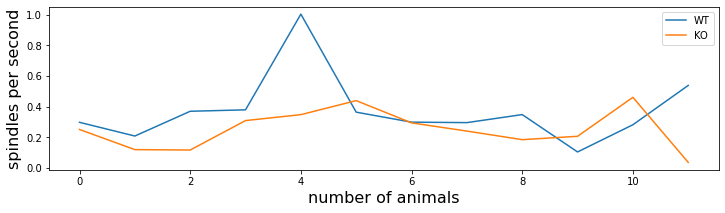

In [55]:
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(sp_second_animal_WT, label='WT')
ax.plot(sp_second_animal_KO, label='KO')
ax.legend(loc='upper right')
ax.set_xlabel('number of animals', fontsize=16)
ax.set_ylabel('spindles per second', fontsize=16)

In [56]:
from scipy.stats import ttest_ind

In [57]:
statistic, pvalue = ttest_ind(sp_second_animal_WT, sp_second_animal_KO)

In [58]:
pvalue

0.11120340184361809

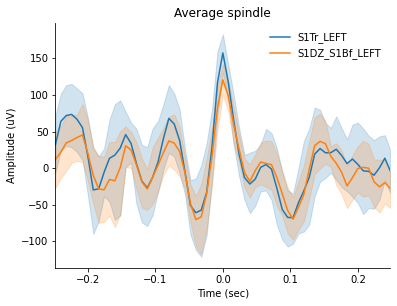

In [59]:
import seaborn as sns
# Plot an average template of the detected slow-waves, centered around the negative peak
ax = sp_per_animal_KO[0][0].plot_average(time_before=0.25, time_after=0.25)
ax.legend(frameon=False)
sns.despine()

In [60]:
list_KO = []
list_diff_KO = []
for n_animal, animal in enumerate(sp_per_animal_KO):
    for elec_tuple in animal:
        # subtracting the spindles data from one electrode to another
        n2sub = int(len(elec_tuple.summary())/2)
        if n2sub > 0:
        
            first_elec = elec_tuple.summary().head(1)['Channel'].tolist()[0]
            sec_elec = elec_tuple.summary().tail(1)['Channel'].tolist()[0]
        
            # Info about the spindles.
            df_single_sp = elec_tuple.summary().round(2)
            df_single_sp['Electrode_1'] = first_elec
            df_single_sp['Electrode_2'] = sec_elec            
            df_single_sp['Animal'] = n_animal
        
            list_KO.append(df_single_sp)
        
            # Check how different the spindles are when they are detected happening at the same time
            df_one = elec_tuple.summary().round(2).head(n2sub).iloc[:, 0:11]
            df_two = elec_tuple.summary().round(2).tail(n2sub).iloc[:, 0:11]
            df_two.reset_index(drop=True, inplace=True)
            df_diff = df_one.sub(df_two, fill_value=0)

            df_diff['Elec_1'] = first_elec
            df_diff['Elec_2'] = sec_elec
            df_diff['Animal'] = n_animal
        
            list_diff_KO.append(df_diff)

df_all_KO_spindles = pd.concat(list_KO)
df_diff_KO_spindles = pd.concat(list_diff_KO)

In [61]:
df_diff

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Elec_1,Elec_2,Animal
0,0.05,0.12,-0.01,-0.06,-18.76,-4.43,-0.1,-0.02,-0.12,0.0,0.18,S1DZ_S1Bf_RIGHT,S1Tr_RIGHT,11


In [62]:
list_WT = []
list_diff_WT = []
for n_animal, animal in enumerate(sp_per_animal_WT):
    for elec_tuple in animal:
        # subtracting the spindles data from one electrode to another
        n2sub = int(len(elec_tuple.summary())/2)
        if n2sub > 0:
        
            first_elec = elec_tuple.summary().head(1)['Channel'].tolist()[0]
            sec_elec = elec_tuple.summary().tail(1)['Channel'].tolist()[0]
        
            # Info about the spindles.
            df_single_sp = elec_tuple.summary().round(2)
            df_single_sp['Electrode_1'] = first_elec
            df_single_sp['Electrode_2'] = sec_elec            
            df_single_sp['Animal'] = n_animal
        
            list_WT.append(df_single_sp)
        
            # Check how different the spindles are when they are detected happening at the same time
            df_one = elec_tuple.summary().round(2).head(n2sub).iloc[:, 0:11]
            df_two = elec_tuple.summary().round(2).tail(n2sub).iloc[:, 0:11]
            df_two.reset_index(drop=True, inplace=True)
            df_diff = df_one.sub(df_two, fill_value=0)

            df_diff['Elec_1'] = first_elec
            df_diff['Elec_2'] = sec_elec
            df_diff['Animal'] = n_animal
        
            list_diff_WT.append(df_diff)
        

df_all_WT_spindles = pd.concat(list_WT)
df_diff_WT_spindles = pd.concat(list_diff_WT)

In [32]:
list_WT = []
list_diff_WT = []
for n_animal, animal in enumerate(sp_per_animal_WT):
    for elec_tuple in animal:
        list_WT.append(elec_tuple.summary().round(2))
        
        # subtracting the spindles data from one electrode to another
        n2sub = int(len(elec_tuple.summary())/2)
        if n2sub > 0:
        
            first_elec = elec_tuple.summary().head(1)['Channel'].tolist()[0]
            sec_elec = elec_tuple.summary().tail(1)['Channel'].tolist()[0]
        
            df_one = elec_tuple.summary().round(2).head(n2sub).iloc[:, 0:11]
            df_two = elec_tuple.summary().round(2).tail(n2sub).iloc[:, 0:11]
            df_two.reset_index(drop=True, inplace=True)
            df_diff = df_one.sub(df_two, fill_value=0)

            df_diff['Elec_1'] = first_elec
            df_diff['Elec_2'] = sec_elec
            df_diff['Animal'] = n_animal
        
            list_diff_WT.append(df_diff)
        

df_all_WT_spindles = pd.concat(list_WT)
df_diff_WT_spindles = pd.concat(list_diff_WT)

In [63]:
os.chdir('/media/jorge/DATADRIVE0/Data/Alfredo/')

In [64]:
writer = pd.ExcelWriter('spindles__short_Dist2.xlsx', engine='xlsxwriter')

df_all_KO_spindles.to_excel(writer,sheet_name = 'shortKO', index = False) #, startrow=20, startcol=0)
df_all_WT_spindles.to_excel(writer,sheet_name = 'shortWT', index = False) #, startrow=20, startcol=0)
writer.save()
writer.close()

/home/jorge/miniconda3/lib/python3.9/site-packages/xlsxwriter/workbook.py:336: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


In [65]:
writer = pd.ExcelWriter('diff_spindles__short_Dist2.xlsx', engine='xlsxwriter')

df_diff_KO_spindles.to_excel(writer,sheet_name = 'shortKO', index = False) #, startrow=20, startcol=0)
df_diff_WT_spindles.to_excel(writer,sheet_name = 'shortWT', index = False) #, startrow=20, startcol=0)
writer.save()
writer.close()

In [66]:
os.getcwd()

'/media/jorge/DATADRIVE0/Data/Alfredo'

### Creating an array of 1s and 0s ind two different ways

In [85]:
n = 100000
m = 100000

In [88]:
%%time
a = np.hstack((np.ones(n), np.zeros(m)))
np.random.shuffle(a)

CPU times: user 11.9 ms, sys: 0 ns, total: 11.9 ms
Wall time: 10.4 ms


In [89]:
%%time
b = np.ones(n+m)
b[:m] = 0
np.random.shuffle(b)

CPU times: user 11.6 ms, sys: 0 ns, total: 11.6 ms
Wall time: 10.5 ms
